In [21]:
# import libraries as necessary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from PIL import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, balanced_accuracy_score, make_scorer, confusion_matrix
from scipy.stats import randint
import xgboost as xgb
import seaborn as sns

In [22]:
data_folder = 'data/'

image_data = []
image_size = (64,64)

for label in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, label)
    
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            image = Image.open(image_path).convert('RGB').resize(image_size)
            image_array = np.array(image).flatten()
            image_data.append((image_array, label))  
df = pd.DataFrame(image_data, columns=['Image', 'Label'])


In [23]:
label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor':3}
df['Label_Int'] = df['Label'].map(label_map)

In [24]:
X = np.stack(df['Image'].values)
y = df['Label_Int'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=6740)

In [25]:
param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

balanced_acc_scorer = make_scorer(balanced_accuracy_score)
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [26]:
rf = RandomForestClassifier(random_state=6740)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20, 
    scoring={'balanced_accuracy': balanced_acc_scorer, 'f2_score': f2_scorer},
    refit='balanced_accuracy', 
    cv=5,  
    random_state=6740,
    n_jobs=-1  
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
y_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 189}


In [27]:
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
y_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': 32, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 189}


In [28]:
# rf = RandomForestClassifier( random_state=6740, max_depth = 32, max_features = None, min_samples_leaf = 1, min_samples_split = 16, n_estimators = 189)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

In [29]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Random Forest Balanced Accuracy: {balanced_acc * 100:.2f}%")
f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print(f"Random Forest F2 Score: {f2_score:.2f}")

Random Forest Balanced Accuracy: 85.82%
Random Forest F2 Score: 0.86


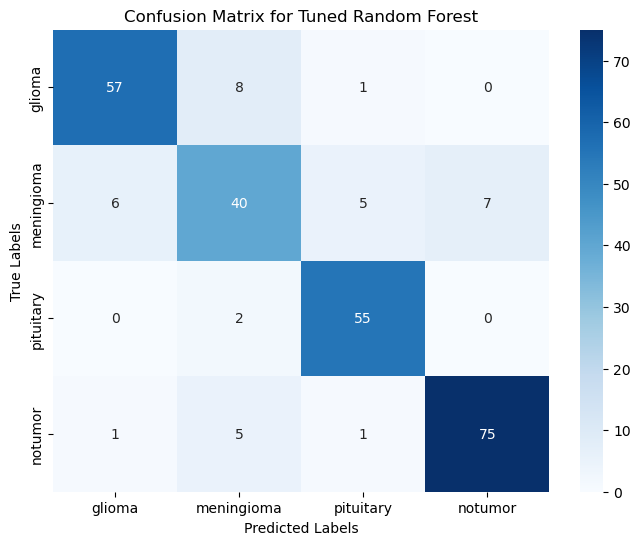

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Tuned Random Forest')
plt.show()

In [17]:
xgb_mod = xgb.XGBClassifier(random_state=6740)
xgb_mod.fit(X_train, y_train)
y_pred = xgb_mod.predict(X_test)

In [18]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"XGBoost Balanced Accuracy: {balanced_acc * 100:.2f}%")
f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print(f"XGBoost F2 Score: {f2_score:.2f}")

XGBoost Balanced Accuracy: 86.34%
XGBoost F2 Score: 0.87
